# Business Problem:
A group of customers were given an offer in person that they can get a loan at discounted rate and
processing fee will be waived off. A pilot campaign was conducted to get response from customers
whether they are interested in taking out a loan or not. Response was recorded and data was collected.

### Need to Do

- [x] Build a model to predict whether customers will be interested in taking out a loan or not.
- [x] Identifying features which are most important
- [ ] In case of black box models e.g. Random forest use SHAP, LIME to figure out features affecting the target variable
- [x] Try Unsupervised clustering models
- [ ] Generate synthetic data for model.
- [x] Approaching a customer has costs involved with it, hence find the profitable segments so that more customized marketing can be done.
- [ ] Need to write inferences what is going on
- [x] Bucketing Age and SCR

Variables involved: `Customer_id`, `Age`, `Gender`, `Balance`, `Occupation`, `No of Credit transaction`, `SCR`, `Holding period`

Bucketed  
Final visualization  
age_d  == 1,2,3,4 vs Target, SCR , _Balance

> ## Understanding Variables


- `Holding Period` (How long the customer is able to hold the money in his account.. So, if they have some existing expenses like a loan EMI or any other monthly expense which gets deducted, usually the first week of every month, hence it makes the balance in the account lower during initial days of the month itself.Higher the holding period, more stable their money is in the account.)

- `SCR` SCR is a score given to a customer for a particular product ( in this case loan ) based on certain parameters, to know whether how likely that customer is to buy that product.. so, higher the score, higher the probability, the customer will buy it.. ###SCR propensity of a customer to respond to a digital marketing


##### Changes v6:
1. Now All Models measure recall on same testing data

2. Fixed Sampling mistake

3. Redefined `print_classification_report` as `classification_report` for better clarity and ease of use

4. Visualized Decision Trees

5. Implemented SVC

6. Implemented KNN which provided great results with default parameters

##### Changes v7:
1. Fit Random Forest Models

2. Fit XgBoost Models

##### Changes v9:
1. Added cross validation

2. Added ROC plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_curve, auc, plot_roc_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

import xgboost as xgb

In [2]:
#from pandasgui import show

In [3]:
data = pd.read_csv('Model_data.csv')
#show(data)

In [4]:
data.Balance = data.Balance.astype('int32') #Truncating decimals

In [5]:
data.head()

Target  Age Gender  Balance Occupation  No_OF_CR_TXNS  SCR  Holding_Period
0       0   41      M    91519   SELF-EMP             38  926              15
1       0   52      M   117288        SAL             17  768              13
2       0   31      F   259827       SENP              8  816               5
3       0   45      F    26677       PROF             14  353              18
4       0   39      F    43440       SENP              1  751              31

In [6]:
data.Balance.describe()

count    2.000000e+04
mean     1.461808e+05
std      1.698125e+05
min      0.000000e+00
25%      2.373650e+04
50%      7.975550e+04
75%      2.173100e+05
max      1.246966e+06
Name: Balance, dtype: float64

In [7]:
data.shape

(20000, 8)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Target          20000 non-null  int64 
 1   Age             20000 non-null  int64 
 2   Gender          20000 non-null  object
 3   Balance         20000 non-null  int32 
 4   Occupation      20000 non-null  object
 5   No_OF_CR_TXNS   20000 non-null  int64 
 6   SCR             20000 non-null  int64 
 7   Holding_Period  20000 non-null  int64 
dtypes: int32(1), int64(5), object(2)
memory usage: 1.1+ MB


`Gender` and `Occupation` are categorical varibles stored as object type

**EDA**

No Strong correlations measured except for mild ones in `Holding_period` and other variables

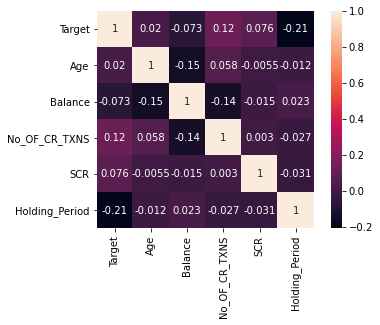

In [9]:
sns.heatmap(data.corr(), annot=True, square=True) # No strong correlations seen overall
plt.show()

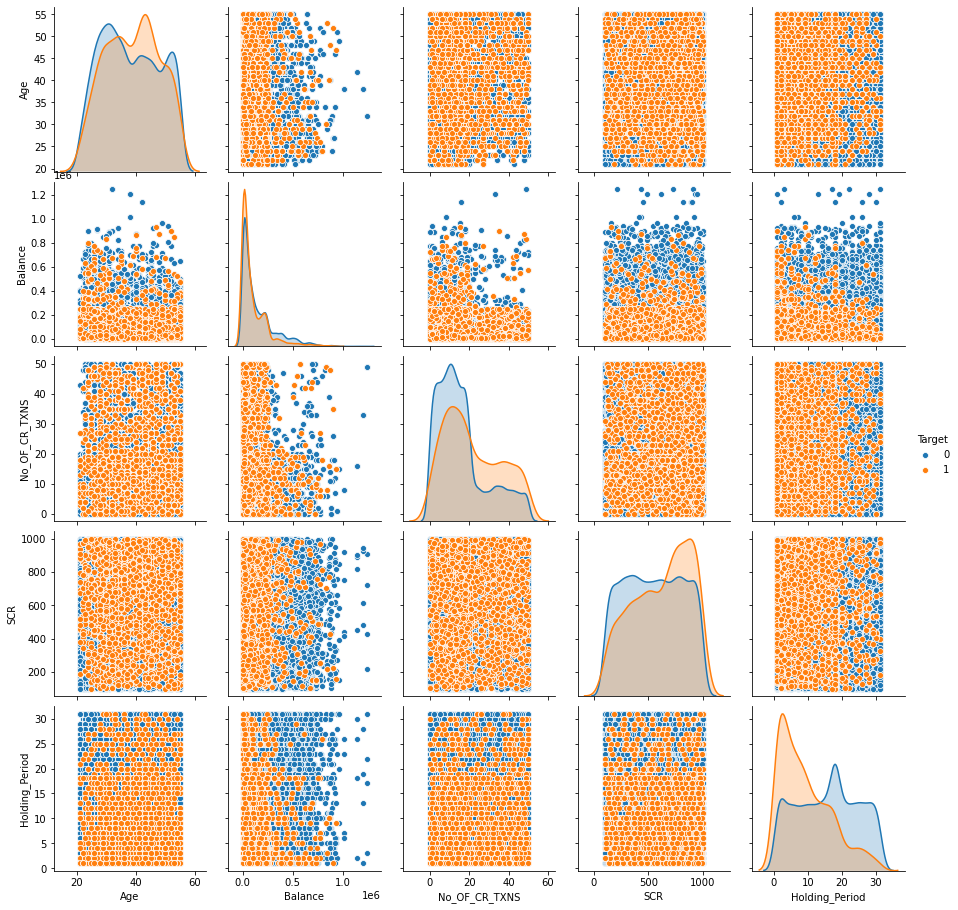

In [10]:
sns.pairplot(data, hue='Target')
plt.show()

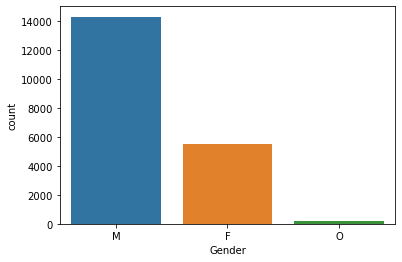

In [11]:
sns.countplot(x = data.Gender)
plt.show()

In [12]:
data.Gender.unique()

array(['M', 'F', 'O'], dtype=object)

In [13]:
data.Occupation.unique()

array(['SELF-EMP', 'SAL', 'SENP', 'PROF'], dtype=object)

In [14]:
data.Gender.value_counts()

M    14279
F     5525
O      196
Name: Gender, dtype: int64

In [15]:
data.drop(data.Gender[data.Gender== 'O'].index, axis = 0, inplace= True) # Removed 196 rows with `Gender` = 'O'

In [16]:
data.shape

(19804, 8)

In [17]:
data.Balance.describe()

count    1.980400e+04
mean     1.465609e+05
std      1.694485e+05
min      0.000000e+00
25%      2.399900e+04
50%      8.035100e+04
75%      2.183090e+05
max      1.246966e+06
Name: Balance, dtype: float64

In [18]:
# sns.histplot(data.Age)

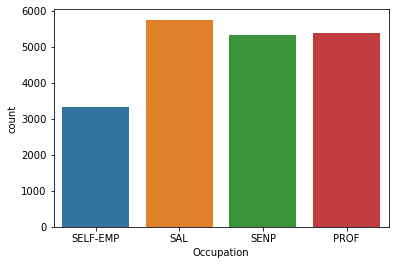

In [19]:
sns.countplot(x = data.Occupation)

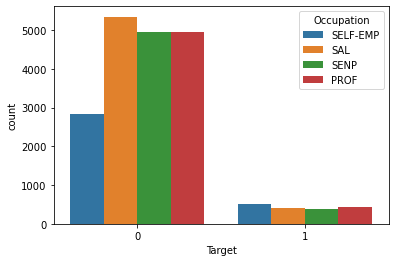

In [20]:
sns.countplot(x=data.Target, hue=data.Occupation) ## Self employed are much more likely to take loans

C:\Anaconda\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


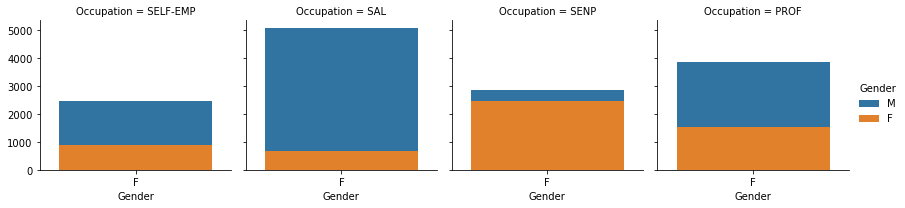

In [21]:
g = sns.FacetGrid(data, col='Occupation', hue="Gender")
plt.grid(True)
g.map(sns.countplot, "Gender", alpha=1)
g.add_legend()
plt.grid((False))

--------------------------

In [22]:
# sns.histplot(data.No_OF_CR_TXNS)

In [23]:
data.No_OF_CR_TXNS.describe()

count    19804.000000
mean        16.563169
std         12.928214
min          0.000000
25%          7.000000
50%         13.000000
75%         21.000000
max         50.000000
Name: No_OF_CR_TXNS, dtype: float64

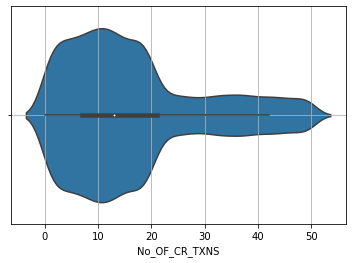

In [24]:
sns.violinplot(x=data.No_OF_CR_TXNS)
plt.grid(True)

In [25]:
# len(data[data.No_OF_CR_TXNS==0].index)

In [26]:
# data.drop(index=data[data.No_OF_CR_TXNS==0].index, axis=0)

------------------

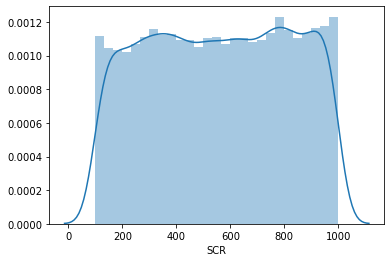

In [27]:
# sns.displot(data.SCR, kind = 'kde')
sns.distplot(data.SCR)
plt.show()

In [28]:
data.SCR.describe()

count    19804.000000
mean       557.115987
std        260.562729
min        100.000000
25%        332.000000
50%        560.500000
75%        784.250000
max        999.000000
Name: SCR, dtype: float64

In [29]:
# sns.histplot(data.Holding_Period)

In [30]:
data3 = data

##### End of Exploratory Data Analysis
-----------
----------

> ### Create a function for easy report printing

In [31]:
# A class for pretty printing
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
# function for validation on test data   
def classification_report(y_true, y_prediction, type_of_data='Enter Over/Under/Original sampled', type_of_classifier='ClassifierName'):
    """Print Classification report"""
    
    accuracy = accuracy_score(y_true, y_prediction)
    precision = precision_score(y_true, y_prediction)
    recall = recall_score(y_true, y_prediction)
    f1 = f1_score(y_true, y_prediction)
    
    print('Classification Report on Testing Data:\n'+ color.BOLD + type_of_data, 'data\n'+color.END+color.RED+color.BOLD+type_of_classifier,'Classifier'+color.END+color.END)
    print()
    print('---------------------------------------')
    print(color.BOLD + 'Recall: %s' %recall + color.END)
    print('Precision: %s' %precision)
    print('F1 score: %s' %f1)
    print('Accuracy: %s' %accuracy)
    print('---------------------------------------')
    print()


# A function for cross-validation report    
def cross_val_report(classifier, train_data, train_label, cv=10, scoring=['recall','precision', 'f1','accuracy']):
    
    score = cross_validate(classifier, train_data, train_label, cv=cv, scoring= scoring)
    recall = np.mean(score['test_recall'])
    precision = np.mean(score['test_precision'])
    f1 = np.mean(score['test_f1'])
    accuracy= np.mean(score['test_accuracy'])
    print('Cross Validation Report')
    print(color.BOLD + 'Recall: %s' %recall + color.END)
    print('Precision: %s' %precision)
    print('F1: %s' %f1)
    print('Accuracy: %s' %accuracy)
    print()
    print("*Mean values presented")
    print('---------------------------------------')

**Create the first set of training and test data on imbalanced data**

In [32]:
df = pd.get_dummies(data, columns=['Gender','Occupation'], drop_first = True)
df.head()

Target  Age  Balance  No_OF_CR_TXNS  SCR  Holding_Period  Gender_M  \
0       0   41    91519             38  926              15         1   
1       0   52   117288             17  768              13         1   
2       0   31   259827              8  816               5         0   
3       0   45    26677             14  353              18         0   
4       0   39    43440              1  751              31         0   

   Occupation_SAL  Occupation_SELF-EMP  Occupation_SENP  
0               0                    1                0  
1               1                    0                0  
2               0                    0                1  
3               0                    0                0  
4               0                    0                1

>**Creating a model with Original Unbalanced data and measuring metrics**

In [33]:
X_original = df.iloc[:,1:]
y_original = df.iloc[:,0]

In [34]:
X_original

Age  Balance  No_OF_CR_TXNS  SCR  Holding_Period  Gender_M  \
0       41    91519             38  926              15         1   
1       52   117288             17  768              13         1   
2       31   259827              8  816               5         0   
3       45    26677             14  353              18         0   
4       39    43440              1  751              31         0   
...    ...      ...            ...  ...             ...       ...   
19995   23    67612             20  164              27         0   
19996   34   472365              8  124               1         0   
19997   42   100642              4  263               1         1   
19998   36    29950             10  345              31         1   
19999   33    48964              4  800              13         1   

       Occupation_SAL  Occupation_SELF-EMP  Occupation_SENP  
0                   0                    1                0  
1                   1                    0                0  
2                   0                    0                1  
3                   0                    0                0  
4                   0                    0                1  
...               ...                  ...              ...  
19995               0                    0                1  
19996               0                    0                0  
19997               1                    0                0  
19998               0                    0                1  
19999               0                    0                0  

[19804 rows x 9 columns]

In [35]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original,y_original, shuffle = ['True'], stratify=y_original)

Classification Report on Testing Data:
Original data
Decision Tree Classifier

---------------------------------------
Recall: 0.04918032786885246
Precision: 0.42
F1 score: 0.0880503144654088
Accuracy: 0.9121389618258937
---------------------------------------



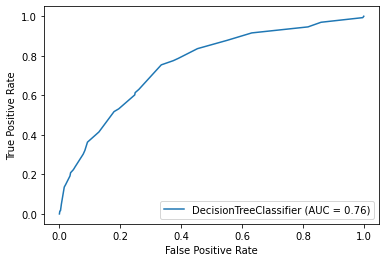

In [36]:
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train_orig, y_train_orig)
y_prediction_orig = clf.predict(X_test_orig)
classification_report(y_test_orig, y_prediction_orig, 'Original', 'Decision Tree')
plot_roc_curve(clf, X_test_orig, y_test_orig)
plt.show()
# cross_val_report(clf, y_test_orig,y_under_prediction.reshape(1,-1))

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
confusion_matrix(y_test_orig, y_prediction_orig)

array([[4495,   29],
       [ 406,   21]], dtype=int64)

In [39]:
# fig = plt.figure(figsize=(50,20))
# _ = plot_tree(clf, 
#                    feature_names=list(X_original.columns),  
#                    class_names=['0','1'],
#                    filled=True, fontsize=10)

-----------

>**Create undersampled data and fit a model**

In [40]:
X_under_train, y_under_train = NearMiss().fit_resample(X_train_orig, y_train_orig)

In [41]:
data[data.Target==1].shape

(1709, 8)

In [42]:
X_under_train.shape, y_under_train.shape

((2564, 9), (2564,))

Classification Report on Testing Data:
Undersampled data
Decision Tree Classifier

---------------------------------------
Recall: 0.7540983606557377
Precision: 0.09168564920273349
F1 score: 0.1634932724041635
Accuracy: 0.3344778832559079
---------------------------------------



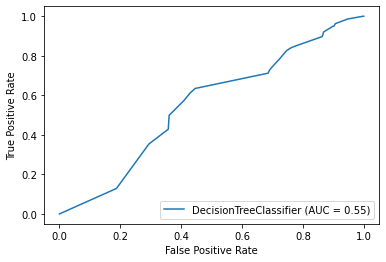

In [43]:
clf_under_sampled = DecisionTreeClassifier(max_depth = 5)
clf_under_sampled.fit(X_under_train, y_under_train)
y_under_prediction = clf_under_sampled.predict(X_test_orig)
classification_report(y_test_orig,y_under_prediction, 'Undersampled', 'Decision Tree')
plot_roc_curve(clf_under_sampled, X_test_orig, y_test_orig)

In [44]:
# cross_val_report(clf_under_sampled, y_test_orig,y_under_prediction)

## crossval here causes unbalanced split

In [45]:
# fig = plt.figure(figsize=(100,100))
# _ = plot_tree(clf_under_sampled, 
#                    feature_names=list(X_original.columns),  
#                    class_names=['0','1'],
#                    filled=True, fontsize=10)

--------------------

> Model on  an oversampled dataset

In [46]:
X_over_train, y_over_train = SMOTE().fit_resample(X_original, y_original)

Classification Report on Testing Data:
Oversampled data
Decision Tree Classifier

---------------------------------------
Recall: 0.6135831381733021
Precision: 0.1767881241565452
F1 score: 0.2744892613933997
Accuracy: 0.7202585336295698
---------------------------------------



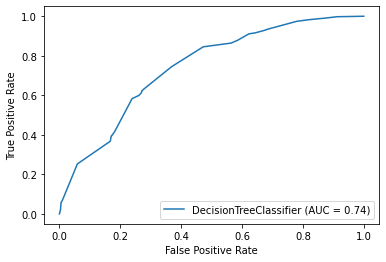

In [47]:
clf_over_sampled = DecisionTreeClassifier(max_depth = 5)
clf_over_sampled.fit(X_over_train, y_over_train)
y_over_predict = clf_over_sampled.predict(X_test_orig)
classification_report(y_test_orig, y_over_predict, 'Oversampled', 'Decision Tree')
plot_roc_curve(clf_over_sampled, X_test_orig, y_test_orig)

In [48]:
# fig = plt.figure(figsize=(100,100))
# _ = plot_tree(clf_over_sampled, 
#                    feature_names=list(X_original.columns),  
#                    class_names=['0','1'],
#                    filled=True, fontsize=10)

---------------

In [49]:
print("Original:     "+color.BOLD+ "X_original,y_original"+color.END+"::  X_train_orig, X_test_orig, y_train_orig, y_test_orig")
print()
print("Undersampled:"+color.BOLD+ " X_under, y_under"+color.END+"     ::  X_under_train, y_under_train")
print()
print("Oversampled:"+color.BOLD+ "  X_over, y_over"+color.END+"       ::  X_over_train, y_over_train")

Original:     X_original,y_original::  X_train_orig, X_test_orig, y_train_orig, y_test_orig

Undersampled: X_under, y_under     ::  X_under_train, y_under_train

Oversampled:  X_over, y_over       ::  X_over_train, y_over_train


The above datasets can be better sampled by adjusting hyper-parameters of NearMiss and SMOTE, or other methods of sampling could be used

-----------
-----------

### SVM Classifiers applied

*SVC fails to fit on original dataset, possibly because of unbalance*

Classification Report on Testing Data:
Undersampled data
SVM Classifier

---------------------------------------
Recall: 0.550351288056206
Precision: 0.07677229663508657
F1 score: 0.13474770642201833
Accuracy: 0.39042617652999395
---------------------------------------

Cross Validation Report
Recall: 0.5155583817829458
Precision: 0.856762028677245
F1: 0.6424574784108211
Accuracy: 0.7136992339494164

*Mean values presented
---------------------------------------


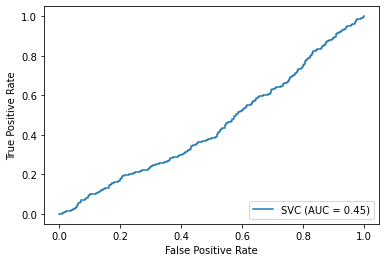

In [50]:
clf_svc0 = SVC()
clf_svc0.fit(X_under_train, y_under_train)
y_predict = clf_svc0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'SVM')
plot_roc_curve(clf_svc0, X_test_orig, y_test_orig)
cross_val_report(clf_svc0, X_under_train, y_under_train)

In [51]:
# %%time
# # Will take LONG Time for Training
# clf_svc1 = SVC()
# clf_svc1.fit(X_over_train, y_over_train)
# y_predict = clf_svc1.predict(X_test_orig)
# classification_report(y_test_orig, y_predict, 'Oversampled', 'SVM')
# plot_roc_curve(clf_svc1, X_test_orig, y_test_orig)
# cross_val_report(clf_svc1, X_under_train, y_under_train)

-------------
--------------------

Classification Report on Testing Data:
Original data
KNN Classifier

---------------------------------------
Recall: 0.06323185011709602
Precision: 0.23893805309734514
F1 score: 0.1
Accuracy: 0.9018380125227227
---------------------------------------

Cross Validation Report
Recall: 0.6021681201550388
Precision: 0.7188602241504229
F1: 0.650485908766395
Accuracy: 0.6743737840466926

*Mean values presented
---------------------------------------


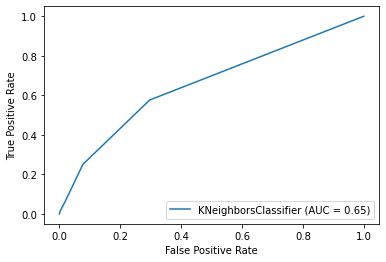

In [52]:
clf_KNN0 = KNeighborsClassifier()
clf_KNN0.fit(X_train_orig, y_train_orig)
y_predict= clf_KNN0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'KNN')
plot_roc_curve(clf_KNN0, X_test_orig, y_test_orig)
cross_val_report(clf_KNN0, X_under_train, y_under_train)

-----------

Classification Report on Testing Data:
Undersampled data
KNN Classifier

---------------------------------------
Recall: 0.7142857142857143
Precision: 0.078125
F1 score: 0.14084507042253522
Accuracy: 0.2484346596647142
---------------------------------------

Cross Validation Report
Recall: 0.6021681201550388
Precision: 0.7188602241504229
F1: 0.650485908766395
Accuracy: 0.6743737840466926

*Mean values presented
---------------------------------------


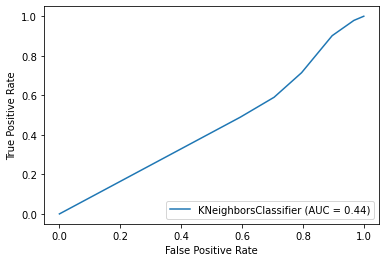

In [53]:
clf_KNN1 = KNeighborsClassifier()
clf_KNN1.fit(X_under_train, y_under_train)
y_predict= clf_KNN1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'KNN')
plot_roc_curve(clf_KNN1, X_test_orig, y_test_orig)
cross_val_report(clf_KNN1, X_under_train, y_under_train)

----------
----------

### Random Forest Classifier Models

Classification Report on Testing Data:
Original data
Random Forest Classifier

---------------------------------------
Recall: 0.11475409836065574
Precision: 0.6282051282051282
F1 score: 0.19405940594059407
Accuracy: 0.9177943849727328
---------------------------------------

Cross Validation Report
Recall: 0.7909883720930233
Precision: 0.7896560936952748
F1: 0.7891872997845422
Accuracy: 0.7886065175097275

*Mean values presented
---------------------------------------


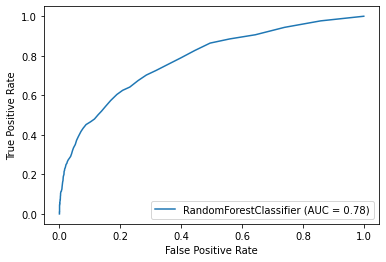

In [54]:
clf_rf0 = RandomForestClassifier()
clf_rf0.fit(X_train_orig, y_train_orig)
y_predict= clf_rf0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'Random Forest')
plot_roc_curve(clf_rf0, X_test_orig, y_test_orig)
cross_val_report(clf_rf0, X_under_train, y_under_train)

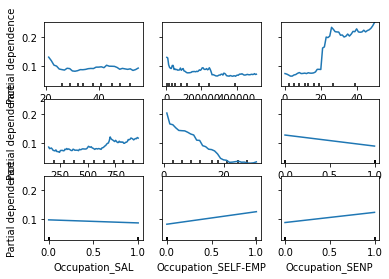

In [55]:
plot_partial_dependence(clf_rf0, X_test_orig, X_test_orig.columns)

-------------

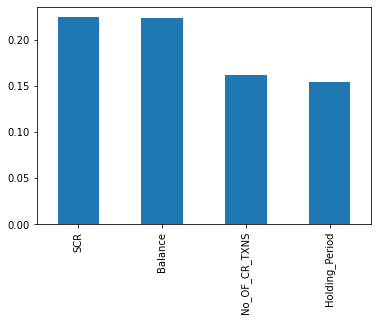

In [56]:
(pd.Series(clf_rf0.feature_importances_, index=X_test_orig.columns)
   .nlargest(4)
   .plot(kind='bar'))

## **RFE Trial**

In [57]:
from sklearn.feature_selection import RFE

In [58]:
rfe = RFE(RandomForestClassifier(), n_features_to_select=4)
rfe = rfe.fit(X_over_train, y_over_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True  True False False False False]
[2 1 1 1 1 5 3 6 4]


In [59]:
categorical_features_indices = np.where(X_train_orig.dtypes != np.float)[0]

In [60]:
#importing library and building model
from catboost import CatBoostRegressor
model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(X_train_orig, y_train_orig,cat_features=categorical_features_indices,eval_set=(X_test_orig, y_test_orig),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2746514	test: 0.2700960	best: 0.2700960 (0)	total: 150ms	remaining: 7.35s
1:	learn: 0.2695106	test: 0.2611647	best: 0.2611647 (1)	total: 154ms	remaining: 3.7s
2:	learn: 0.2651414	test: 0.2535639	best: 0.2535639 (2)	total: 162ms	remaining: 2.53s
3:	learn: 0.2615590	test: 0.2473106	best: 0.2473106 (3)	total: 165ms	remaining: 1.9s
4:	learn: 0.2584076	test: 0.2429018	best: 0.2429018 (4)	total: 169ms	remaining: 1.52s
5:	learn: 0.2559668	test: 0.2385712	best: 0.2385712 (5)	total: 173ms	remaining: 1.27s
6:	learn: 0.2537854	test: 0.2356387	best: 0.2356387 (6)	total: 180ms	remaining: 1.11s
7:	learn: 0.2520764	test: 0.2325478	best: 0.2325478 (7)	total: 184ms	remaining: 966ms
8:	learn: 0.2506499	test: 0.2299154	best: 0.2299154 (8)	total: 188ms	remaining: 855ms
9:	learn: 0.2492573	test: 0.2281399	best: 0.2281399 (9)	total: 192ms	remaining: 767ms
10:	learn: 0.2481891	test: 0.2261043	best: 0.2261043 (10)	total: 195ms	remaining: 693ms
11:	learn: 0.2472053	test: 0.2249049	best: 0.2249049 (

In [62]:
shap.summary_plot(shap_values, X_test_orig)

NameError: name 'shap' is not defined

In [63]:
help(CatBoostClassifier)

NameError: name 'CatBoostClassifier' is not defined

In [64]:
X_train_orig.columns

Index(['Age', 'Balance', 'No_OF_CR_TXNS', 'SCR', 'Holding_Period', 'Gender_M',
       'Occupation_SAL', 'Occupation_SELF-EMP', 'Occupation_SENP'],
      dtype='object')

Classification Report on Testing Data:
Undersampled data
Random Forest Classifier

---------------------------------------
Recall: 0.8430913348946136
Precision: 0.103956107421311
F1 score: 0.18508997429305912
Accuracy: 0.3597253080185821
---------------------------------------

Cross Validation Report
Recall: 0.7917514534883721
Precision: 0.8030155363964994
F1: 0.7966639241192632
Accuracy: 0.7975635335603113

*Mean values presented
---------------------------------------


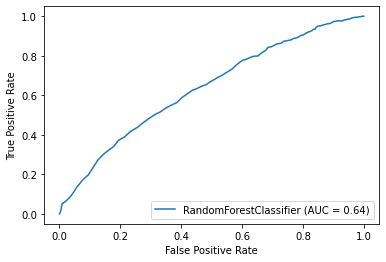

In [65]:
clf_rf1 = RandomForestClassifier()
clf_rf1.fit(X_under_train, y_under_train)
y_predict= clf_rf1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'Random Forest')
plot_roc_curve(clf_rf1, X_test_orig, y_test_orig)
cross_val_report(clf_rf1, X_under_train, y_under_train)

-------------

In [66]:
clf_rf2 = RandomForestClassifier()

Classification Report on Testing Data:
Oversampled data
Random Forest Classifier

---------------------------------------
Recall: 0.8430913348946136
Precision: 0.10332950631458095
F1 score: 0.18409613909486067
Accuracy: 0.35548374065845284
---------------------------------------

Cross Validation Report
Recall: 0.7862887596899225
Precision: 0.7924655526288069
F1: 0.7887268621085213
Accuracy: 0.788986502918288

*Mean values presented
---------------------------------------


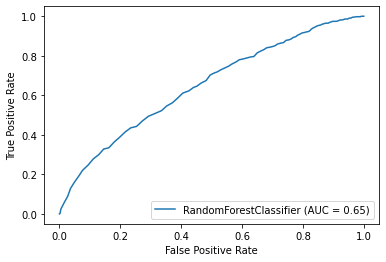

In [67]:
clf_rf2.fit(X_under_train, y_under_train)
y_predict= clf_rf2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'Random Forest')
plot_roc_curve(clf_rf2, X_test_orig, y_test_orig)
cross_val_report(clf_rf2, X_under_train, y_under_train)

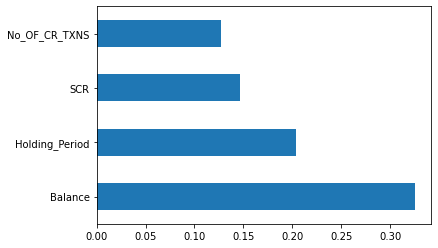

In [68]:
(pd.Series(clf_rf2.feature_importances_, index=X_test_orig.columns)
   .nlargest(4)
   .plot(kind='barh'))

----------
----------------

In [69]:
# rfe = RFE(KNeighborsClassifier(), n_features_to_select=4)
# rfe = rfe.fit(X_train_orig, y_train_orig)
# # summarize the selection of the attributes
# print(rfe.saupport_)
# print(rfe.ranking_)

------
------

In [70]:
lr0 = LogisticRegression(max_iter=1000)
lr0.fit(X_train_orig, y_train_orig)
y_predict= lr0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'Logistic Regression')
plot_roc_curve(lr0, X_test_orig, y_test_orig)
cross_val_report(lr0, X_under_train, y_under_train)

NameError: name 'LogisticRegression' is not defined

In [ ]:
lr1 = LogisticRegression(max_iter=100)
lr1.fit(X_under_train, y_under_train)
y_predict= lr1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'Logistic Regression')
plot_roc_curve(lr1, X_test_orig, y_test_orig)
cross_val_report(lr1, X_under_train, y_under_train)

In [ ]:
lr2 = LogisticRegression(max_iter=100)
lr2.fit(X_over_train, y_over_train)
y_predict= lr2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'Logistic Regression')
plot_roc_curve(lr1, X_test_orig, y_test_orig)
cross_val_report(lr1, X_under_train, y_under_train)

------
------

In [ ]:
clf_KNN2 = KNeighborsClassifier()
clf_KNN2.fit(X_over_train, y_over_train)
y_predict= clf_KNN2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'KNN')
plot_roc_curve(clf_KNN2, X_test_orig, y_test_orig)
cross_val_report(clf_KNN2, X_under_train, y_under_train)

**_Segment the customer with prob >90, 80>prob>90, 70>prob>80, 60>prob>70 and so on_**

In [ ]:
predict_prob = clf_KNN2.predict_proba(X_test_orig)
predict_prob.shape
# print more significant digits here

In [ ]:
# predict_prob

In [ ]:
predictions = pd.DataFrame(predict_prob, columns=[0, 'PredictionProb'])

In [ ]:
# predictions.head()

In [71]:
predictions_prob = predictions.drop(0, axis=1)

NameError: name 'predictions' is not defined

In [72]:
y = pd.DataFrame(y_test_orig, columns = ['Target'])
y = y.reset_index(drop=True)

In [73]:
error = y.Target- predictions_prob.PredictionProb

NameError: name 'predictions_prob' is not defined

In [74]:
# This series indicate the error, closer to zero values mean better prediction
# positive mean that my model should have predicted loan taker, but did not
# negative means that model should have predicted NOT a loan taker, but did predict as such

In [75]:
# target - probablity

In [76]:
plt.hist(error)
plt.xlabel('Error in Prediction: Target - Probablity Of Prediction')
plt.ylabel("Count")
plt.show()

NameError: name 'error' is not defined

## PRE-BUCKETING VISUALIZATIONS FOR INFERENCES

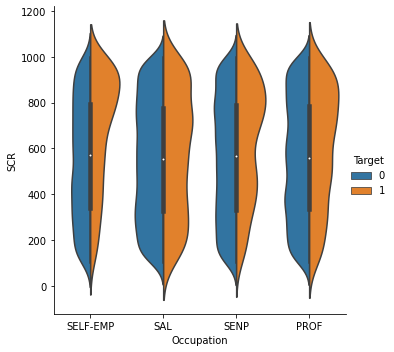

In [77]:
sns.catplot(x="Occupation", y="SCR", hue = "Target",data=data, kind = "violin", split = True)
plt.show()

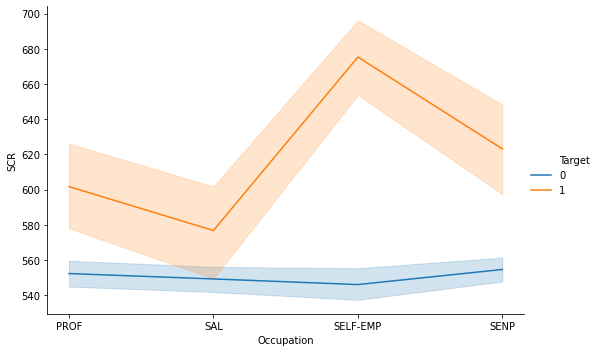

In [78]:
sns.relplot(x="Occupation", y="SCR", hue = "Target",data=data, aspect=1.5, kind = "line")
plt.show()

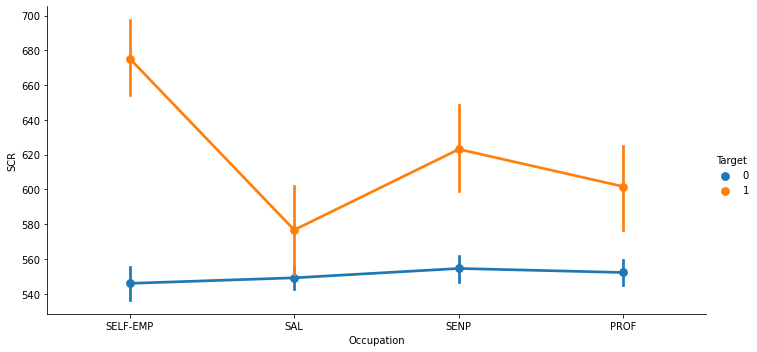

In [79]:
sns.catplot(x="Occupation", y="SCR", hue = "Target",data=data, aspect=2.0, kind = "point")
plt.show()

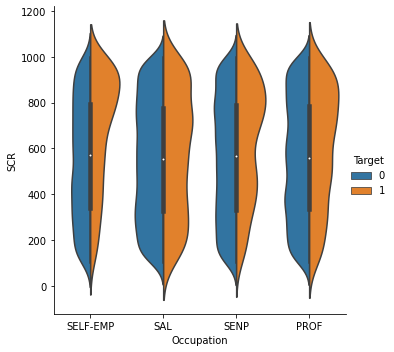

In [80]:
sns.catplot(x="Occupation", y="SCR", hue = "Target",data=data, kind = "violin", split = True)
plt.show()

The model is good, make few mistakes

In [81]:
data1 = data.copy()

## Bucketing for AGE values

In [82]:
data1['Ageb'] = pd.qcut(data['Age'], q=4)

In [83]:
data1.head()

Target  Age Gender  Balance Occupation  No_OF_CR_TXNS  SCR  Holding_Period  \
0       0   41      M    91519   SELF-EMP             38  926              15   
1       0   52      M   117288        SAL             17  768              13   
2       0   31      F   259827       SENP              8  816               5   
3       0   45      F    26677       PROF             14  353              18   
4       0   39      F    43440       SENP              1  751              31   

           Ageb  
0  (38.0, 46.0]  
1  (46.0, 55.0]  
2  (30.0, 38.0]  
3  (38.0, 46.0]  
4  (38.0, 46.0]

In [84]:
data1.Ageb.value_counts()

(30.0, 38.0]      5188
(20.999, 30.0]    5136
(46.0, 55.0]      4936
(38.0, 46.0]      4544
Name: Ageb, dtype: int64

In [85]:
data1.dtypes

Target               int64
Age                  int64
Gender              object
Balance              int32
Occupation          object
No_OF_CR_TXNS        int64
SCR                  int64
Holding_Period       int64
Ageb              category
dtype: object

In [86]:
data1.Ageb

0          (38.0, 46.0]
1          (46.0, 55.0]
2          (30.0, 38.0]
3          (38.0, 46.0]
4          (38.0, 46.0]
              ...      
19995    (20.999, 30.0]
19996      (30.0, 38.0]
19997      (38.0, 46.0]
19998      (30.0, 38.0]
19999      (30.0, 38.0]
Name: Ageb, Length: 19804, dtype: category
Categories (4, interval[float64]): [(20.999, 30.0] < (30.0, 38.0] < (38.0, 46.0] < (46.0, 55.0]]

In [87]:
data1.head(5)

Target  Age Gender  Balance Occupation  No_OF_CR_TXNS  SCR  Holding_Period  \
0       0   41      M    91519   SELF-EMP             38  926              15   
1       0   52      M   117288        SAL             17  768              13   
2       0   31      F   259827       SENP              8  816               5   
3       0   45      F    26677       PROF             14  353              18   
4       0   39      F    43440       SENP              1  751              31   

           Ageb  
0  (38.0, 46.0]  
1  (46.0, 55.0]  
2  (30.0, 38.0]  
3  (38.0, 46.0]  
4  (38.0, 46.0]

In [88]:
# sns.pairplot(data1, hue='Target')

In [89]:
data1 = pd.get_dummies(data1)

In [90]:
data1.head(2)

Target  Age  Balance  No_OF_CR_TXNS  SCR  Holding_Period  Gender_F  \
0       0   41    91519             38  926              15         0   
1       0   52   117288             17  768              13         0   

   Gender_M  Occupation_PROF  Occupation_SAL  Occupation_SELF-EMP  \
0         1                0               0                    1   
1         1                0               1                    0   

   Occupation_SENP  Ageb_(20.999, 30.0]  Ageb_(30.0, 38.0]  Ageb_(38.0, 46.0]  \
0                0                    0                  0                  1   
1                0                    0                  0                  0   

   Ageb_(46.0, 55.0]  
0                  0  
1                  1

In [91]:
data2 = data1.copy()

In [92]:
data1.columns

Index(['Target', 'Age', 'Balance', 'No_OF_CR_TXNS', 'SCR', 'Holding_Period',
       'Gender_F', 'Gender_M', 'Occupation_PROF', 'Occupation_SAL',
       'Occupation_SELF-EMP', 'Occupation_SENP', 'Ageb_(20.999, 30.0]',
       'Ageb_(30.0, 38.0]', 'Ageb_(38.0, 46.0]', 'Ageb_(46.0, 55.0]'],
      dtype='object')

In [93]:
cols = ['Ageb_(30.0, 38.0]', 'Ageb_(20.999, 30.0]','Ageb_(46.0, 55.0]','Ageb_(38.0, 46.0]']

def func1(x):
    if x ==1:
        return 1
def func2(x):
    if x ==1:
        return 2

def func3(x):
    if x ==1:
        return 3

def func4(x):
    if x ==1:
        return 4


data1['age_d'] = data1['Ageb_(30.0, 38.0]'].apply(func1)
data1['age_d'] = data1['Ageb_(20.999, 30.0]'].apply(func2)
data1['age_d'] = data1['Ageb_(46.0, 55.0]'].apply(func3)
data1['age_d'] = data1['Ageb_(38.0, 46.0]'].apply(func4)

In [94]:
for ind, row in data1.iterrows():
    if row['Ageb_(20.999, 30.0]'] ==1:
        data1.loc[ind, 'age_d'] = 1
    elif row['Ageb_(30.0, 38.0]'] ==1:
        data1.loc[ind, 'age_d'] = 2
    elif row['Ageb_(38.0, 46.0]'] ==1:
        data1.loc[ind, 'age_d'] = 3
    elif row['Ageb_(46.0, 55.0]'] ==1:
        data1.loc[ind, 'age_d'] = 4

In [95]:
data1.age_d.value_counts()

2.0    5188
1.0    5136
4.0    4936
3.0    4544
Name: age_d, dtype: int64

In [96]:
data1.age_d = data1.age_d.astype('int32')

In [97]:
data1.head()

Target  Age  Balance  No_OF_CR_TXNS  SCR  Holding_Period  Gender_F  \
0       0   41    91519             38  926              15         0   
1       0   52   117288             17  768              13         0   
2       0   31   259827              8  816               5         1   
3       0   45    26677             14  353              18         1   
4       0   39    43440              1  751              31         1   

   Gender_M  Occupation_PROF  Occupation_SAL  Occupation_SELF-EMP  \
0         1                0               0                    1   
1         1                0               1                    0   
2         0                0               0                    0   
3         0                1               0                    0   
4         0                0               0                    0   

   Occupation_SENP  Ageb_(20.999, 30.0]  Ageb_(30.0, 38.0]  Ageb_(38.0, 46.0]  \
0                0                    0                  0                  1   
1                0                    0                  0                  0   
2                1                    0                  1                  0   
3                0                    0                  0                  1   
4                1                    0                  0                  1   

   Ageb_(46.0, 55.0]  age_d  
0                  0      3  
1                  1      4  
2                  0      2  
3                  0      3  
4                  0      3

## POST-BUCKETING VISUALIZATIONS FOR INFERENCES

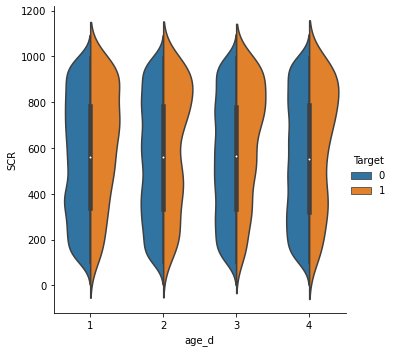

In [98]:
sns.catplot(x="age_d", y="SCR", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

In [99]:
data1.columns

Index(['Target', 'Age', 'Balance', 'No_OF_CR_TXNS', 'SCR', 'Holding_Period',
       'Gender_F', 'Gender_M', 'Occupation_PROF', 'Occupation_SAL',
       'Occupation_SELF-EMP', 'Occupation_SENP', 'Ageb_(20.999, 30.0]',
       'Ageb_(30.0, 38.0]', 'Ageb_(38.0, 46.0]', 'Ageb_(46.0, 55.0]', 'age_d'],
      dtype='object')

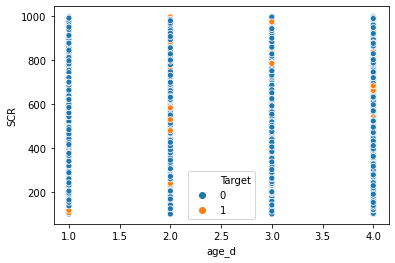

In [100]:
sns.scatterplot(x='age_d', y="SCR", hue = "Target",data=data1,)
plt.show()

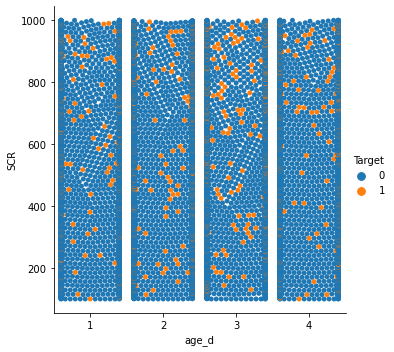

In [101]:
sns.catplot(x="age_d", y="SCR", hue = "Target",data=data1, kind = "swarm")
plt.show()

In [102]:
sns.set_style('ticks')

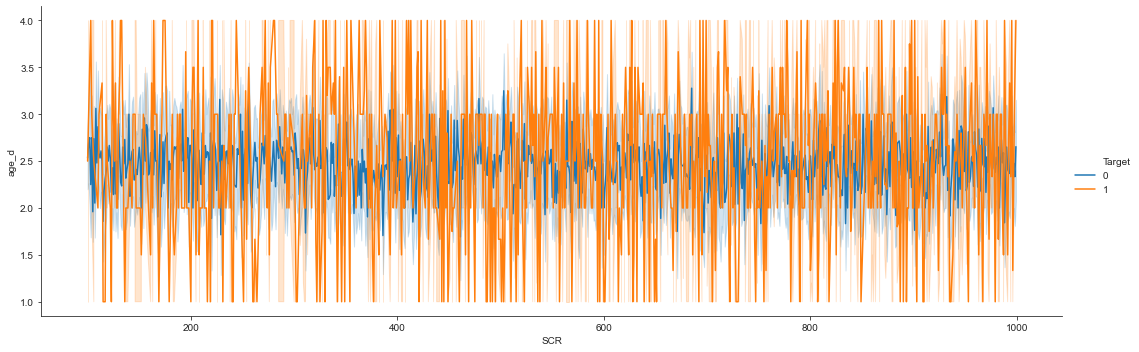

In [103]:
g = sns.relplot(x="SCR", y="age_d", hue = "Target",data=data1, aspect=3, kind = "line")
# g.figure.set_size_inches(18.5, 10.5)
# sns.despine()

## BUCKETING SCR & HOLDING PERIODS

In [104]:
data1['SCRb'] = pd.qcut(data['SCR'], q=5)

In [105]:
data1.SCRb.value_counts()

(99.999, 288.0]    3987
(468.0, 651.0]     3964
(826.0, 999.0]     3956
(651.0, 826.0]     3952
(288.0, 468.0]     3945
Name: SCRb, dtype: int64

In [106]:
data1['HPB'] = pd.qcut(data['Holding_Period'], q=4)

In [107]:
data1.HPB.value_counts()

(0.999, 8.0]    5519
(16.0, 23.0]    4998
(8.0, 16.0]     4791
(23.0, 31.0]    4496
Name: HPB, dtype: int64

In [108]:
data1.head()

Target  Age  Balance  No_OF_CR_TXNS  SCR  Holding_Period  Gender_F  \
0       0   41    91519             38  926              15         0   
1       0   52   117288             17  768              13         0   
2       0   31   259827              8  816               5         1   
3       0   45    26677             14  353              18         1   
4       0   39    43440              1  751              31         1   

   Gender_M  Occupation_PROF  Occupation_SAL  Occupation_SELF-EMP  \
0         1                0               0                    1   
1         1                0               1                    0   
2         0                0               0                    0   
3         0                1               0                    0   
4         0                0               0                    0   

   Occupation_SENP  Ageb_(20.999, 30.0]  Ageb_(30.0, 38.0]  Ageb_(38.0, 46.0]  \
0                0                    0                  0                  1   
1                0                    0                  0                  0   
2                1                    0                  1                  0   
3                0                    0                  0                  1   
4                1                    0                  0                  1   

   Ageb_(46.0, 55.0]  age_d            SCRb           HPB  
0                  0      3  (826.0, 999.0]   (8.0, 16.0]  
1                  1      4  (651.0, 826.0]   (8.0, 16.0]  
2                  0      2  (651.0, 826.0]  (0.999, 8.0]  
3                  0      3  (288.0, 468.0]  (16.0, 23.0]  
4                  0      3  (651.0, 826.0]  (23.0, 31.0]

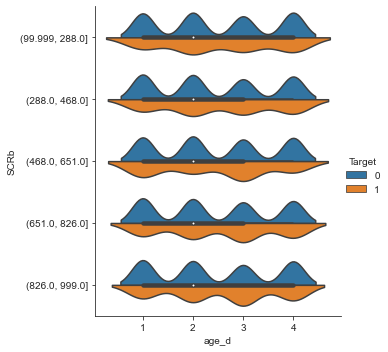

In [109]:
sns.catplot(x="age_d", y="SCRb", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

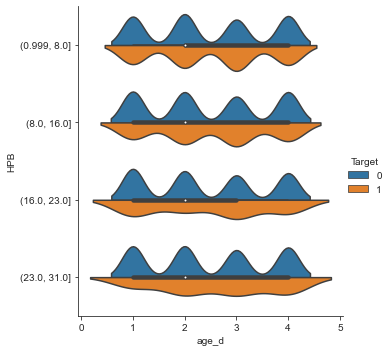

In [110]:
sns.catplot(x="age_d", y="HPB", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.


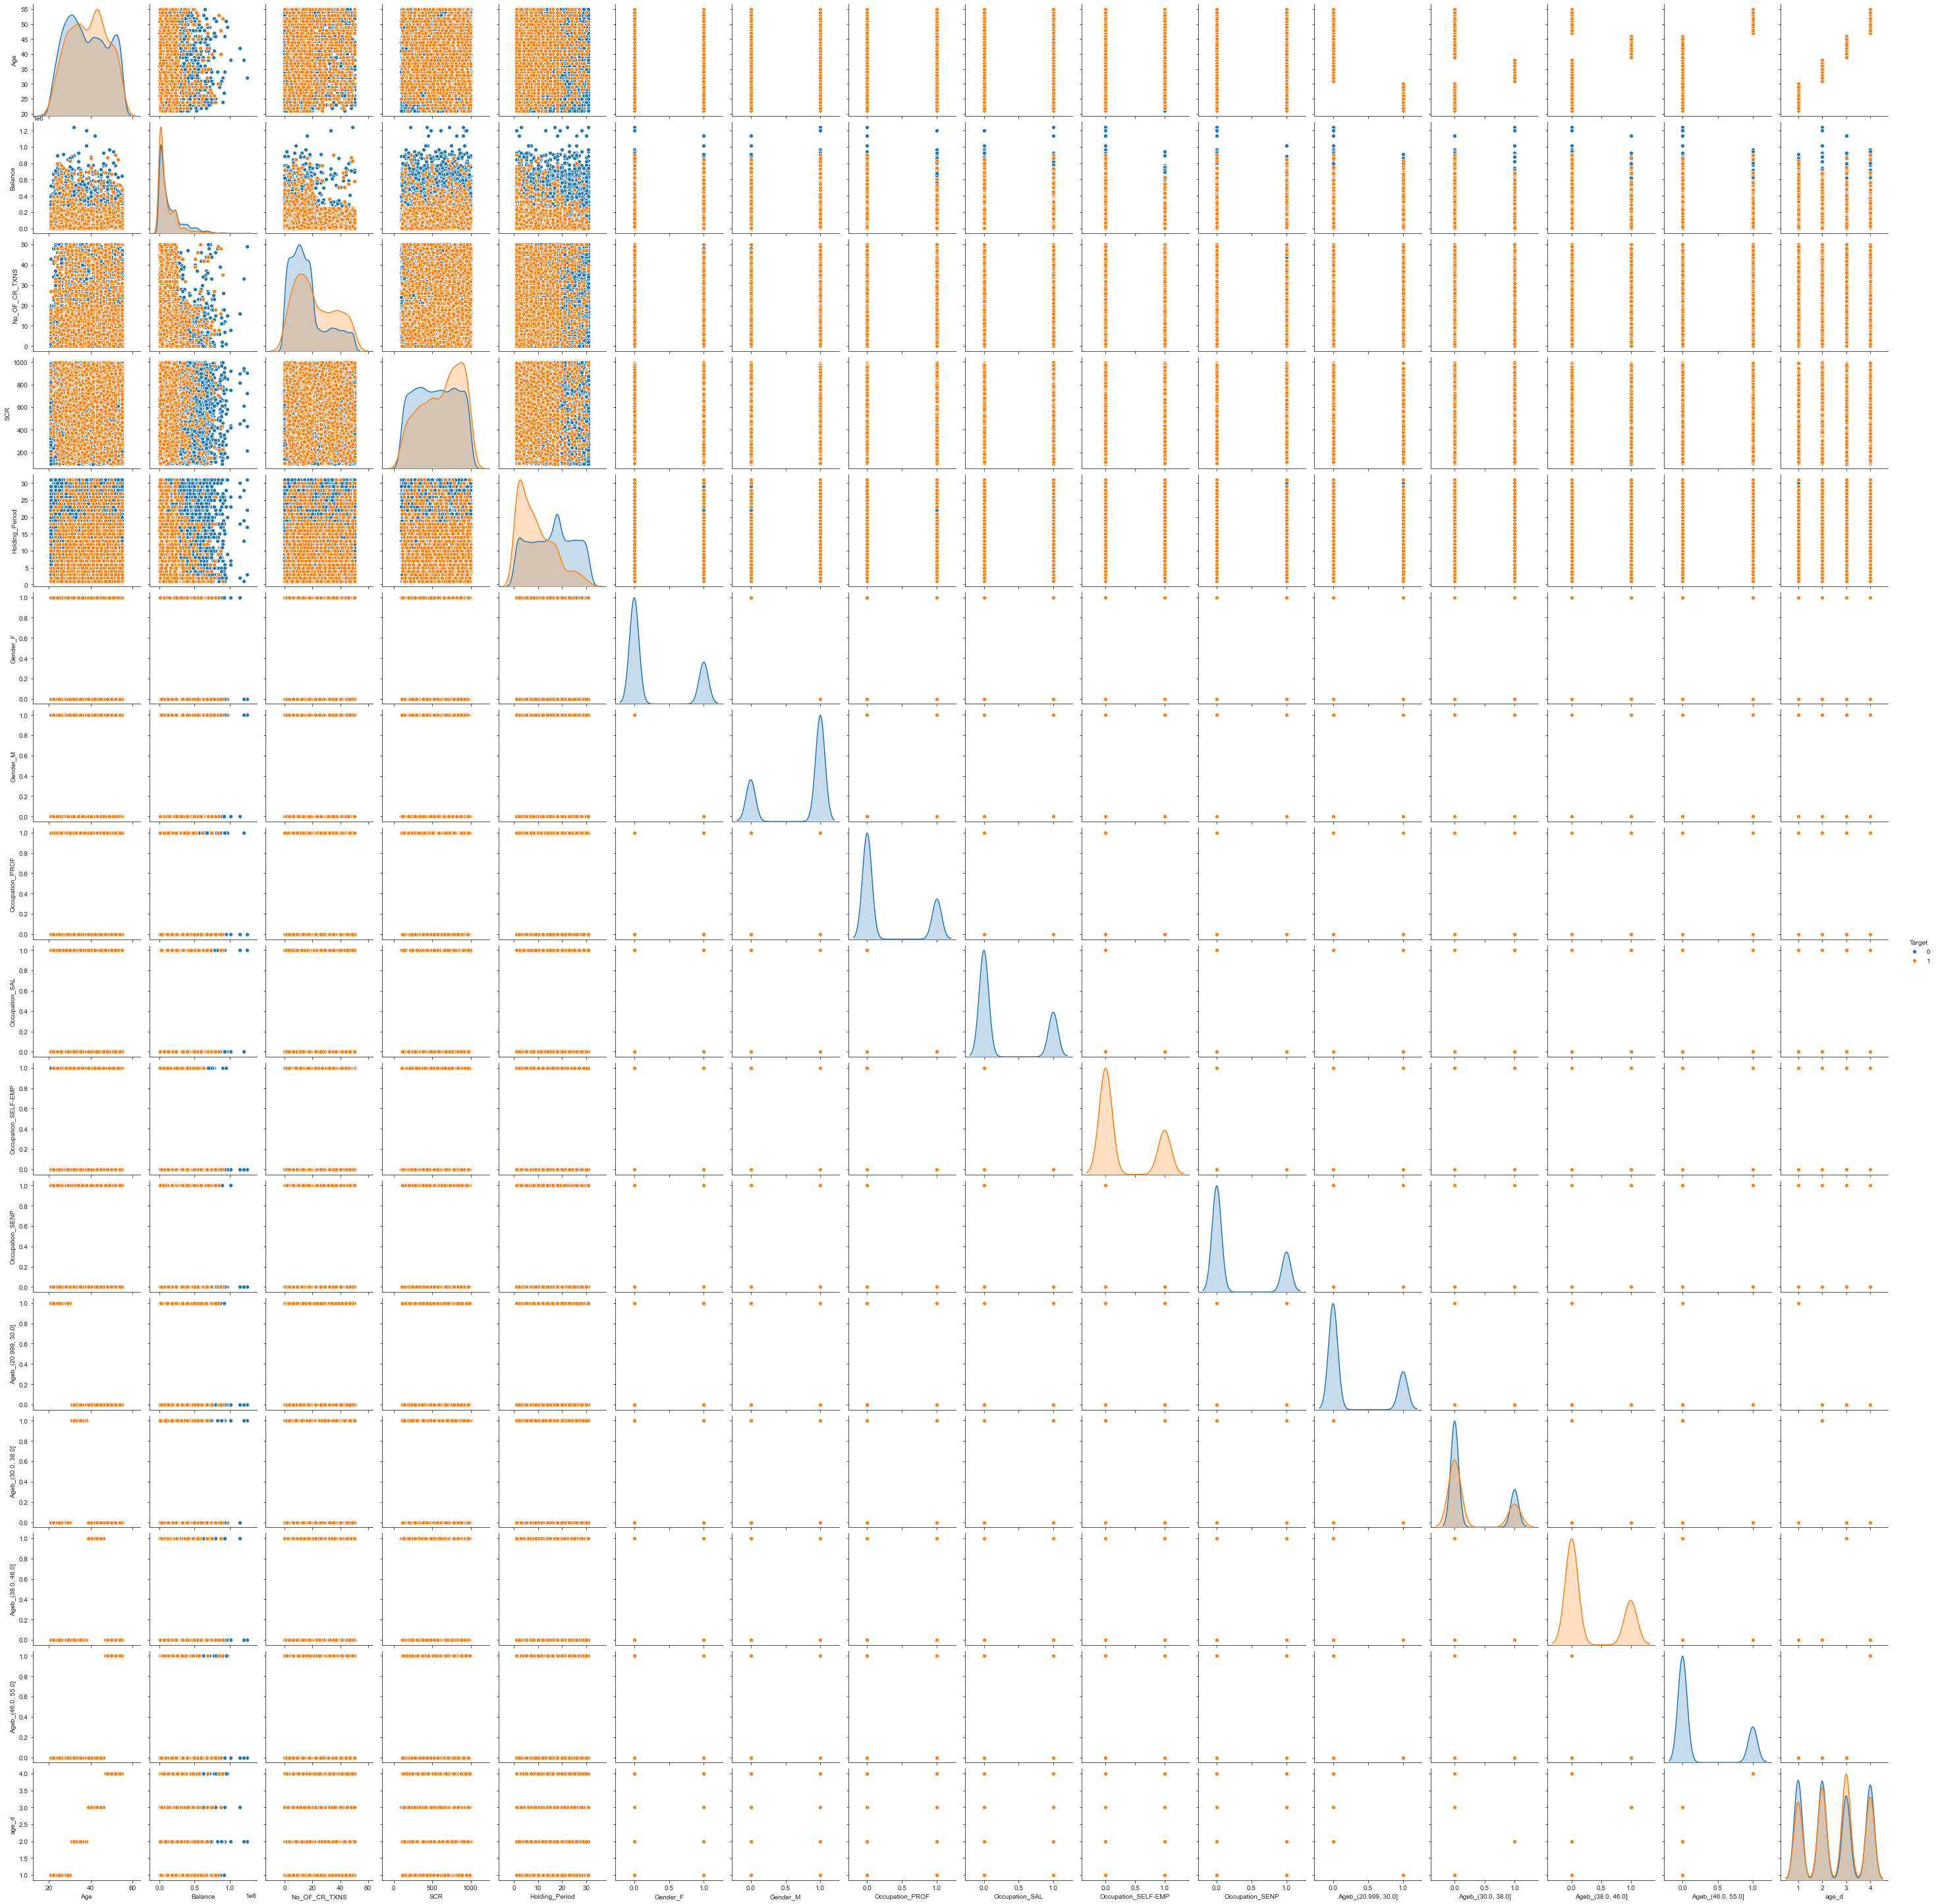

In [116]:
sns.pairplot(data1, hue = 'Target')
plt.show()

## SHAP

In [111]:
import shap

In [112]:
X_train_summary = shap.kmeans(X_train_orig, 10)

In [113]:
explainerKNN = shap.KernelExplainer(clf_KNN0.predict,X_train_summary)

In [114]:
shap_values_KNN_test = explainerKNN.shap_values(X_test_orig)

KeyboardInterrupt: 

In [ ]:
shap.initjs()
shap.force_plot(explainerKNN.expected_value, shap_values_KNN_test[:1000,:], X_test_orig.iloc[:1000,:])

## LIME

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
lgb_params = {
    'task': 'train',
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric':'binary_logloss',
    'metric': {'l2', 'auc'},
    'num_leaves': 50,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': None,
    'num_iteration':100,
    'num_threads':7,
    'max_depth':12,
    'min_data_in_leaf':100,
    'alpha':0.5}

In [ ]:
import warnings
from lime import submodular_pick
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train_orig, y_train_orig)
lgb_eval = lgb.Dataset(X_test_orig, y_test_orig)

model = lgb.train(lgb_params,lgb_train,num_boost_round=20,valid_sets=lgb_eval,early_stopping_rounds=5)
lime.lime_tabular.LimeTabularExplainer(data[model.feature_name()].astype(int).values,  
mode='classification',training_labels=data3['Target'],feature_names=model.feature_name())
# Remember to convert the dataframe to matrix values
# SP-LIME returns exaplanations on a sample set to provide a non redundant global decision boundary of original model
sp_obj = submodular_pick.SubmodularPick(explainer,data3[model.feature_name()].values, \
prob, num_features=5,num_exps_desired=10)

[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]

In [119]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=1500, learning_rate=0.01, l2_leaf_reg=3.5, depth=5, rsm=0.98, 
                           loss_function= 'Logloss', eval_metric='AUC',use_best_model=True,random_seed=42)

In [122]:
cate_features_index = np.where(data.dtypes != float)[0]

In [123]:
model.fit(X_train_orig,y_train_orig,cat_features=cate_features_index,eval_set=(X_test_orig,y_test_orig))

0:	test: 0.7088303	best: 0.7088303 (0)	total: 91.9ms	remaining: 2m 17s
1:	test: 0.7088303	best: 0.7088303 (0)	total: 154ms	remaining: 1m 55s
2:	test: 0.7088303	best: 0.7088303 (0)	total: 162ms	remaining: 1m 20s
3:	test: 0.7437683	best: 0.7437683 (3)	total: 189ms	remaining: 1m 10s
4:	test: 0.7490941	best: 0.7490941 (4)	total: 214ms	remaining: 1m 3s
5:	test: 0.7525746	best: 0.7525746 (5)	total: 237ms	remaining: 59s
6:	test: 0.7534930	best: 0.7534930 (6)	total: 261ms	remaining: 55.8s
7:	test: 0.7555706	best: 0.7555706 (7)	total: 272ms	remaining: 50.8s
8:	test: 0.7522242	best: 0.7555706 (7)	total: 281ms	remaining: 46.6s
9:	test: 0.7512243	best: 0.7555706 (7)	total: 326ms	remaining: 48.5s
10:	test: 0.7489704	best: 0.7555706 (7)	total: 336ms	remaining: 45.4s
11:	test: 0.7489704	best: 0.7555706 (7)	total: 342ms	remaining: 42.4s
12:	test: 0.7489704	best: 0.7555706 (7)	total: 349ms	remaining: 39.9s
13:	test: 0.7489704	best: 0.7555706 (7)	total: 356ms	remaining: 37.8s
14:	test: 0.7489714	best: 0

125:	test: 0.8420451	best: 0.8423418 (121)	total: 2.12s	remaining: 23.1s
126:	test: 0.8420112	best: 0.8423418 (121)	total: 2.13s	remaining: 23s
127:	test: 0.8419750	best: 0.8423418 (121)	total: 2.14s	remaining: 22.9s
128:	test: 0.8418740	best: 0.8423418 (121)	total: 2.16s	remaining: 22.9s
129:	test: 0.8420110	best: 0.8423418 (121)	total: 2.17s	remaining: 22.9s
130:	test: 0.8419043	best: 0.8423418 (121)	total: 2.18s	remaining: 22.8s
131:	test: 0.8418779	best: 0.8423418 (121)	total: 2.2s	remaining: 22.8s
132:	test: 0.8422506	best: 0.8423418 (121)	total: 2.21s	remaining: 22.7s
133:	test: 0.8424463	best: 0.8424463 (133)	total: 2.26s	remaining: 23s
134:	test: 0.8423718	best: 0.8424463 (133)	total: 2.27s	remaining: 23s
135:	test: 0.8421777	best: 0.8424463 (133)	total: 2.29s	remaining: 23s
136:	test: 0.8421761	best: 0.8424463 (133)	total: 2.3s	remaining: 22.9s
137:	test: 0.8421761	best: 0.8424463 (133)	total: 2.31s	remaining: 22.8s
138:	test: 0.8425644	best: 0.8425644 (138)	total: 2.32s	remai

240:	test: 0.8463257	best: 0.8463971 (239)	total: 3.77s	remaining: 19.7s
241:	test: 0.8463014	best: 0.8463971 (239)	total: 3.78s	remaining: 19.6s
242:	test: 0.8463480	best: 0.8463971 (239)	total: 3.79s	remaining: 19.6s
243:	test: 0.8462926	best: 0.8463971 (239)	total: 3.8s	remaining: 19.6s
244:	test: 0.8463762	best: 0.8463971 (239)	total: 3.82s	remaining: 19.6s
245:	test: 0.8463710	best: 0.8463971 (239)	total: 3.83s	remaining: 19.5s
246:	test: 0.8463482	best: 0.8463971 (239)	total: 3.84s	remaining: 19.5s
247:	test: 0.8462633	best: 0.8463971 (239)	total: 3.85s	remaining: 19.5s
248:	test: 0.8465429	best: 0.8465429 (248)	total: 3.87s	remaining: 19.4s
249:	test: 0.8465517	best: 0.8465517 (249)	total: 3.88s	remaining: 19.4s
250:	test: 0.8465776	best: 0.8465776 (250)	total: 3.89s	remaining: 19.4s
251:	test: 0.8466376	best: 0.8466376 (251)	total: 3.91s	remaining: 19.4s
252:	test: 0.8467784	best: 0.8467784 (252)	total: 3.92s	remaining: 19.3s
253:	test: 0.8467515	best: 0.8467784 (252)	total: 3.

354:	test: 0.8485879	best: 0.8485879 (354)	total: 5.61s	remaining: 18.1s
355:	test: 0.8486241	best: 0.8486241 (355)	total: 5.63s	remaining: 18.1s
356:	test: 0.8486790	best: 0.8486790 (356)	total: 5.64s	remaining: 18.1s
357:	test: 0.8487660	best: 0.8487660 (357)	total: 5.66s	remaining: 18s
358:	test: 0.8489637	best: 0.8489637 (358)	total: 5.69s	remaining: 18.1s
359:	test: 0.8488757	best: 0.8489637 (358)	total: 5.71s	remaining: 18.1s
360:	test: 0.8488550	best: 0.8489637 (358)	total: 5.72s	remaining: 18.1s
361:	test: 0.8487634	best: 0.8489637 (358)	total: 5.73s	remaining: 18s
362:	test: 0.8487582	best: 0.8489637 (358)	total: 5.74s	remaining: 18s
363:	test: 0.8487572	best: 0.8489637 (358)	total: 5.75s	remaining: 18s
364:	test: 0.8487515	best: 0.8489637 (358)	total: 5.77s	remaining: 17.9s
365:	test: 0.8487189	best: 0.8489637 (358)	total: 5.78s	remaining: 17.9s
366:	test: 0.8487562	best: 0.8489637 (358)	total: 5.8s	remaining: 17.9s
367:	test: 0.8488483	best: 0.8489637 (358)	total: 5.83s	rema

474:	test: 0.8491910	best: 0.8495932 (413)	total: 8.19s	remaining: 17.7s
475:	test: 0.8492019	best: 0.8495932 (413)	total: 8.2s	remaining: 17.6s
476:	test: 0.8491962	best: 0.8495932 (413)	total: 8.21s	remaining: 17.6s
477:	test: 0.8492743	best: 0.8495932 (413)	total: 8.25s	remaining: 17.6s
478:	test: 0.8492899	best: 0.8495932 (413)	total: 8.27s	remaining: 17.6s
479:	test: 0.8493049	best: 0.8495932 (413)	total: 8.31s	remaining: 17.7s
480:	test: 0.8493271	best: 0.8495932 (413)	total: 8.32s	remaining: 17.6s
481:	test: 0.8493453	best: 0.8495932 (413)	total: 8.33s	remaining: 17.6s
482:	test: 0.8493561	best: 0.8495932 (413)	total: 8.34s	remaining: 17.6s
483:	test: 0.8493157	best: 0.8495932 (413)	total: 8.39s	remaining: 17.6s
484:	test: 0.8493178	best: 0.8495932 (413)	total: 8.4s	remaining: 17.6s
485:	test: 0.8493090	best: 0.8495932 (413)	total: 8.41s	remaining: 17.5s
486:	test: 0.8493261	best: 0.8495932 (413)	total: 8.42s	remaining: 17.5s
487:	test: 0.8493199	best: 0.8495932 (413)	total: 8.4

587:	test: 0.8492355	best: 0.8495932 (413)	total: 10.2s	remaining: 15.7s
588:	test: 0.8492365	best: 0.8495932 (413)	total: 10.2s	remaining: 15.8s
589:	test: 0.8492365	best: 0.8495932 (413)	total: 10.3s	remaining: 15.9s
590:	test: 0.8492448	best: 0.8495932 (413)	total: 10.3s	remaining: 15.8s
591:	test: 0.8492474	best: 0.8495932 (413)	total: 10.4s	remaining: 15.9s
592:	test: 0.8492319	best: 0.8495932 (413)	total: 10.4s	remaining: 15.9s
593:	test: 0.8492158	best: 0.8495932 (413)	total: 10.4s	remaining: 15.9s
594:	test: 0.8491993	best: 0.8495932 (413)	total: 10.4s	remaining: 15.9s
595:	test: 0.8491729	best: 0.8495932 (413)	total: 10.5s	remaining: 15.9s
596:	test: 0.8491625	best: 0.8495932 (413)	total: 10.5s	remaining: 15.9s
597:	test: 0.8491931	best: 0.8495932 (413)	total: 10.6s	remaining: 15.9s
598:	test: 0.8491977	best: 0.8495932 (413)	total: 10.6s	remaining: 15.9s
599:	test: 0.8492583	best: 0.8495932 (413)	total: 10.6s	remaining: 15.9s
600:	test: 0.8492531	best: 0.8495932 (413)	total: 1

701:	test: 0.8493468	best: 0.8495932 (413)	total: 13.3s	remaining: 15.1s
702:	test: 0.8493546	best: 0.8495932 (413)	total: 13.3s	remaining: 15.1s
703:	test: 0.8493753	best: 0.8495932 (413)	total: 13.4s	remaining: 15.1s
704:	test: 0.8493530	best: 0.8495932 (413)	total: 13.4s	remaining: 15.1s
705:	test: 0.8493598	best: 0.8495932 (413)	total: 13.4s	remaining: 15.1s
706:	test: 0.8493463	best: 0.8495932 (413)	total: 13.4s	remaining: 15s
707:	test: 0.8493178	best: 0.8495932 (413)	total: 13.5s	remaining: 15.1s
708:	test: 0.8493261	best: 0.8495932 (413)	total: 13.6s	remaining: 15.1s
709:	test: 0.8493049	best: 0.8495932 (413)	total: 13.6s	remaining: 15.1s
710:	test: 0.8493411	best: 0.8495932 (413)	total: 13.6s	remaining: 15.1s
711:	test: 0.8493106	best: 0.8495932 (413)	total: 13.6s	remaining: 15.1s
712:	test: 0.8492987	best: 0.8495932 (413)	total: 13.7s	remaining: 15.1s
713:	test: 0.8493261	best: 0.8495932 (413)	total: 13.7s	remaining: 15.1s
714:	test: 0.8493059	best: 0.8495932 (413)	total: 13.

817:	test: 0.8495420	best: 0.8496693 (802)	total: 15.7s	remaining: 13.1s
818:	test: 0.8495430	best: 0.8496693 (802)	total: 15.7s	remaining: 13.1s
819:	test: 0.8495616	best: 0.8496693 (802)	total: 15.8s	remaining: 13.1s
820:	test: 0.8495637	best: 0.8496693 (802)	total: 15.8s	remaining: 13s
821:	test: 0.8495606	best: 0.8496693 (802)	total: 15.8s	remaining: 13s
822:	test: 0.8495699	best: 0.8496693 (802)	total: 15.8s	remaining: 13s
823:	test: 0.8496258	best: 0.8496693 (802)	total: 15.8s	remaining: 13s
824:	test: 0.8496331	best: 0.8496693 (802)	total: 15.8s	remaining: 12.9s
825:	test: 0.8496704	best: 0.8496704 (825)	total: 15.8s	remaining: 12.9s
826:	test: 0.8496704	best: 0.8496704 (825)	total: 15.8s	remaining: 12.9s
827:	test: 0.8496512	best: 0.8496704 (825)	total: 15.9s	remaining: 12.9s
828:	test: 0.8496533	best: 0.8496704 (825)	total: 15.9s	remaining: 12.8s
829:	test: 0.8496455	best: 0.8496704 (825)	total: 15.9s	remaining: 12.8s
830:	test: 0.8496564	best: 0.8496704 (825)	total: 15.9s	rem

932:	test: 0.8498546	best: 0.8498665 (922)	total: 17.6s	remaining: 10.7s
933:	test: 0.8498546	best: 0.8498665 (922)	total: 17.6s	remaining: 10.7s
934:	test: 0.8498443	best: 0.8498665 (922)	total: 17.6s	remaining: 10.6s
935:	test: 0.8498489	best: 0.8498665 (922)	total: 17.6s	remaining: 10.6s
936:	test: 0.8498205	best: 0.8498665 (922)	total: 17.6s	remaining: 10.6s
937:	test: 0.8498215	best: 0.8498665 (922)	total: 17.6s	remaining: 10.6s
938:	test: 0.8498241	best: 0.8498665 (922)	total: 17.7s	remaining: 10.6s
939:	test: 0.8498308	best: 0.8498665 (922)	total: 17.7s	remaining: 10.5s
940:	test: 0.8498220	best: 0.8498665 (922)	total: 17.7s	remaining: 10.5s
941:	test: 0.8498117	best: 0.8498665 (922)	total: 17.7s	remaining: 10.5s
942:	test: 0.8498200	best: 0.8498665 (922)	total: 17.7s	remaining: 10.5s
943:	test: 0.8498272	best: 0.8498665 (922)	total: 17.7s	remaining: 10.4s
944:	test: 0.8498376	best: 0.8498665 (922)	total: 17.7s	remaining: 10.4s
945:	test: 0.8498577	best: 0.8498665 (922)	total: 1

1058:	test: 0.8502910	best: 0.8503035 (1057)	total: 19.6s	remaining: 8.18s
1059:	test: 0.8502631	best: 0.8503035 (1057)	total: 19.6s	remaining: 8.15s
1060:	test: 0.8502817	best: 0.8503035 (1057)	total: 19.7s	remaining: 8.15s
1061:	test: 0.8502915	best: 0.8503035 (1057)	total: 19.7s	remaining: 8.13s
1062:	test: 0.8502900	best: 0.8503035 (1057)	total: 19.7s	remaining: 8.11s
1063:	test: 0.8502786	best: 0.8503035 (1057)	total: 19.7s	remaining: 8.08s
1064:	test: 0.8502760	best: 0.8503035 (1057)	total: 19.7s	remaining: 8.06s
1065:	test: 0.8503112	best: 0.8503112 (1065)	total: 19.7s	remaining: 8.04s
1066:	test: 0.8503029	best: 0.8503112 (1065)	total: 19.8s	remaining: 8.02s
1067:	test: 0.8503009	best: 0.8503112 (1065)	total: 19.8s	remaining: 8s
1068:	test: 0.8502900	best: 0.8503112 (1065)	total: 19.8s	remaining: 7.98s
1069:	test: 0.8502926	best: 0.8503112 (1065)	total: 19.8s	remaining: 7.96s
1070:	test: 0.8502895	best: 0.8503112 (1065)	total: 19.8s	remaining: 7.94s
1071:	test: 0.8502941	best: 

1170:	test: 0.8503097	best: 0.8504427 (1139)	total: 21.3s	remaining: 5.98s
1171:	test: 0.8502947	best: 0.8504427 (1139)	total: 21.3s	remaining: 5.96s
1172:	test: 0.8503154	best: 0.8504427 (1139)	total: 21.3s	remaining: 5.94s
1173:	test: 0.8503159	best: 0.8504427 (1139)	total: 21.3s	remaining: 5.92s
1174:	test: 0.8503154	best: 0.8504427 (1139)	total: 21.3s	remaining: 5.9s
1175:	test: 0.8502838	best: 0.8504427 (1139)	total: 21.4s	remaining: 5.88s
1176:	test: 0.8502952	best: 0.8504427 (1139)	total: 21.4s	remaining: 5.86s
1177:	test: 0.8503827	best: 0.8504427 (1139)	total: 21.4s	remaining: 5.84s
1178:	test: 0.8503920	best: 0.8504427 (1139)	total: 21.4s	remaining: 5.82s
1179:	test: 0.8503863	best: 0.8504427 (1139)	total: 21.4s	remaining: 5.8s
1180:	test: 0.8503739	best: 0.8504427 (1139)	total: 21.4s	remaining: 5.78s
1181:	test: 0.8503733	best: 0.8504427 (1139)	total: 21.4s	remaining: 5.76s
1182:	test: 0.8503682	best: 0.8504427 (1139)	total: 21.4s	remaining: 5.74s
1183:	test: 0.8503661	best:

1289:	test: 0.8506011	best: 0.8506208 (1276)	total: 22.8s	remaining: 3.71s
1290:	test: 0.8506172	best: 0.8506208 (1276)	total: 22.8s	remaining: 3.69s
1291:	test: 0.8506234	best: 0.8506234 (1291)	total: 22.8s	remaining: 3.67s
1292:	test: 0.8506234	best: 0.8506234 (1291)	total: 22.8s	remaining: 3.65s
1293:	test: 0.8506016	best: 0.8506234 (1291)	total: 22.8s	remaining: 3.63s
1294:	test: 0.8505990	best: 0.8506234 (1291)	total: 22.8s	remaining: 3.61s
1295:	test: 0.8506006	best: 0.8506234 (1291)	total: 22.8s	remaining: 3.6s
1296:	test: 0.8505985	best: 0.8506234 (1291)	total: 22.9s	remaining: 3.58s
1297:	test: 0.8506078	best: 0.8506234 (1291)	total: 22.9s	remaining: 3.56s
1298:	test: 0.8506047	best: 0.8506234 (1291)	total: 22.9s	remaining: 3.54s
1299:	test: 0.8505980	best: 0.8506234 (1291)	total: 22.9s	remaining: 3.52s
1300:	test: 0.8505726	best: 0.8506234 (1291)	total: 22.9s	remaining: 3.5s
1301:	test: 0.8505949	best: 0.8506234 (1291)	total: 22.9s	remaining: 3.48s
1302:	test: 0.8505933	best:

1412:	test: 0.8505390	best: 0.8506819 (1346)	total: 24.2s	remaining: 1.49s
1413:	test: 0.8505380	best: 0.8506819 (1346)	total: 24.2s	remaining: 1.47s
1414:	test: 0.8505576	best: 0.8506819 (1346)	total: 24.2s	remaining: 1.46s
1415:	test: 0.8505732	best: 0.8506819 (1346)	total: 24.2s	remaining: 1.44s
1416:	test: 0.8505763	best: 0.8506819 (1346)	total: 24.3s	remaining: 1.42s
1417:	test: 0.8505701	best: 0.8506819 (1346)	total: 24.3s	remaining: 1.4s
1418:	test: 0.8505794	best: 0.8506819 (1346)	total: 24.3s	remaining: 1.39s
1419:	test: 0.8505726	best: 0.8506819 (1346)	total: 24.3s	remaining: 1.37s
1420:	test: 0.8505851	best: 0.8506819 (1346)	total: 24.3s	remaining: 1.35s
1421:	test: 0.8505778	best: 0.8506819 (1346)	total: 24.3s	remaining: 1.33s
1422:	test: 0.8505644	best: 0.8506819 (1346)	total: 24.3s	remaining: 1.31s
1423:	test: 0.8505669	best: 0.8506819 (1346)	total: 24.3s	remaining: 1.3s
1424:	test: 0.8505488	best: 0.8506819 (1346)	total: 24.3s	remaining: 1.28s
1425:	test: 0.8505178	best:

In [131]:
test = pd.read_csv("F:\\IBPA_IIM_FinalProject\\Test_targets.csv")
pred = model.predict_proba(test.iloc[:,0])

CatBoostError: Invalid cat_features[1] = 1 value: index must be < 1.